In [1]:
import torch
import torch.nn as nn

import tvm
from tvm.auto_scheduler.search_task import SearchTask
from tvm.auto_scheduler.measure_record import RecordReader, load_best_record

# import timeit

# from brt.runtime import BRT_KERNEL_TEMPLATE_PATH, BRT_LOG_PATH
from brt.jit.tvm import TVMTuner
from brt.jit.tvm.utils import parse_culaunch_config
from brt.jit.compiler import CUDACompiler
from brt.jit.codegen import ModuleKernel

from classsr_rcan import parse_params


/home/v-louyang/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tvm_tuner = TVMTuner()
conv2d = nn.Conv2d(50, 50, 3, padding=1)
in_shape = [50, 50, 32, 32]
out_shape = [50, 50, 32, 32]
input_infos = {"input_0": in_shape}
output_infos = {"output_0": out_shape}
parameters = {
    "in_channels": 50,
    "out_channels": 50,
    "kernel_size": (3, 3),
    "stride": (1, 1),
    "padding": (1, 1),
    "dilation": (1, 1),
    "groups": 1,
    # "bias": True,
    "padding_mode": "zeros",
}
tvm_tuner.import_pt_netlet(
    "Conv2dBias", "forward", conv2d, input_infos, output_infos, parameters
)

in_tensor = torch.randn(in_shape, device="cuda")
out_tensor = torch.randn(out_shape, device="cuda")
weight = torch.randn(
    parameters["out_channels"],
    parameters["in_channels"],
    *parameters["kernel_size"],
    device="cuda",
)
bias = torch.randn(parameters["out_channels"], device="cuda")


Get devices for measurement successfully!


/home/v-louyang/brainstorm_project/brainstorm/3rdparty/tvm/python/tvm/driver/build_module.py:267: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  warnings.warn(


In [3]:
# %timeit -n 1000 -r 100 fastest_kernel(in_tensor, weight, out_tensor, bias)


In [4]:
# %timeit -n 1000 -r 100 most_efficient_kernel(in_tensor, weight, out_tensor, bias)


In [5]:
# print(f"""{fastest_source_code.replace("\\n", "\n") = }""")
# print(f"""{most_efficient_source_code.replace("\\n", "\n") = }""")


In [6]:
import os
import numpy as np
import pandas as pd
import random as rd

from tvm import auto_scheduler

BRT_LOG_PATH = "/home/v-louyang/brainstorm_project/brainstorm/.cache/log/"
KERNEL_TUNE_PATH = BRT_LOG_PATH + "kernel_tune/NVIDIA_A100_80GB_PCIe/"

conv2d_files = []
for record_file in os.listdir(KERNEL_TUNE_PATH):
    if "Conv2dBias_forward_input_0_50_50_32_32_output_0_50_50_32_32" in record_file:
        conv2d_files.append(record_file)
record_file = rd.choice(conv2d_files)
print(f"### Analyse {record_file}...")
record_reader = auto_scheduler.RecordReader(KERNEL_TUNE_PATH + record_file)
data = np.ones((len(list(record_reader)), 4), np.float64)
record_reader = auto_scheduler.RecordReader(KERNEL_TUNE_PATH + record_file)
for i, (inp, res) in enumerate(record_reader):
    # if res.error_no != 0:
    #     continue
    tvm_sch, tvm_args = tvm_tuner.tvm_task.compute_dag.apply_steps_from_state(inp.state)
    tvm_ir = tvm.lower(tvm_sch, tvm_args, simple_mode=True)
    grid_dim, block_dim = parse_culaunch_config(tvm_ir)
    mean_cost = sum(res.costs) / len(res.costs)
    data[i] = [
        grid_dim[0] * grid_dim[1] * grid_dim[2],
        block_dim[0] * block_dim[1] * block_dim[2],
        mean_cost,
        grid_dim[0] * mean_cost,
    ]


print(data)
# data = np.array(data, dtype=np.float64)
# input(f"### Analyse {record_file} finished. Press Enter to continue...")


### Analyse Conv2dBias_forward_input_0_50_50_32_32_output_0_50_50_32_32_in_channels_50_out_channels_50_kernel_size_3_3_stride_1_1_padding_1_1_dilation_1_1_groups_1.json...
[[1.00000000e+02 8.00000000e+02 2.58076500e-04 2.58076500e-02]
 [8.00000000e+01 4.00000000e+01 6.23754000e-03 4.99003200e-01]
 [3.20000000e+01 1.00000000e+02 2.36990250e-03 7.58368800e-02]
 ...
 [3.20000000e+02 4.00000000e+02 1.33776250e-03 4.28084000e-01]
 [1.60000000e+01 4.00000000e+01 2.53368750e-02 4.05390000e-01]
 [2.50000000e+02 1.28000000e+02 1.92747250e-04 4.81868125e-02]]


In [7]:
df = pd.DataFrame(
    data,
    columns=["block_num", "thread_num", "lantency", "sm_cost"],
    dtype=np.float64,
)
print(df.max()["lantency"])
print(df.min()["lantency"])
print(df.max()["sm_cost"])
print(df.min()["sm_cost"])

df_sort_lantency = df.sort_values("lantency")
df_sort_lantency_top = df_sort_lantency.head(len(df_sort_lantency) * 9 // 10)
print(df_sort_lantency_top.head(3))

df_sort_sm_cost = df.sort_values("sm_cost")
df_sort_sm_cost_top = df_sort_sm_cost.head(len(df_sort_sm_cost) * 9 // 10)
print(df_sort_sm_cost_top.head(3))


10000000000.0
0.0001823775
250000000000.0
0.0231556875
      block_num  thread_num  lantency   sm_cost
1160      250.0       128.0  0.000182  0.045594
1350      250.0       128.0  0.000183  0.045630
1100      250.0       128.0  0.000183  0.045634
     block_num  thread_num  lantency   sm_cost
86        50.0       800.0  0.000463  0.023156
25        50.0       320.0  0.000476  0.023821
126      100.0       256.0  0.000256  0.025597


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


<AxesSubplot: xlabel='block_num', ylabel='lantency'>

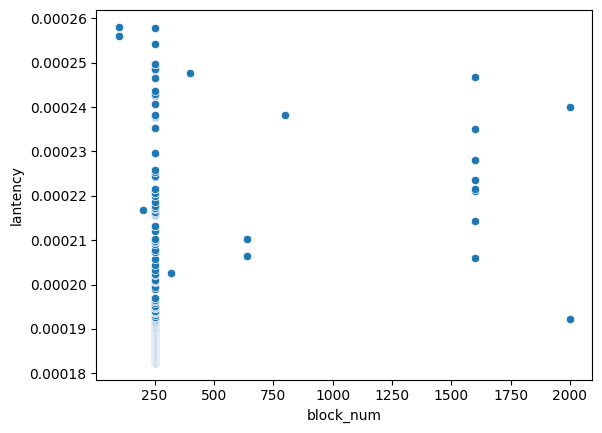

In [9]:
sns.scatterplot(
    data=df_sort_lantency_top,
    x="block_num",
    y="lantency",
    # hue="lantency",
    # hue_norm=(df_sort_lantency_top.min()["lantency"], df_sort_lantency_top.max()["lantency"]),
    # palette="flare",
    # legend="brief",
)


<AxesSubplot: xlabel='block_num', ylabel='lantency'>

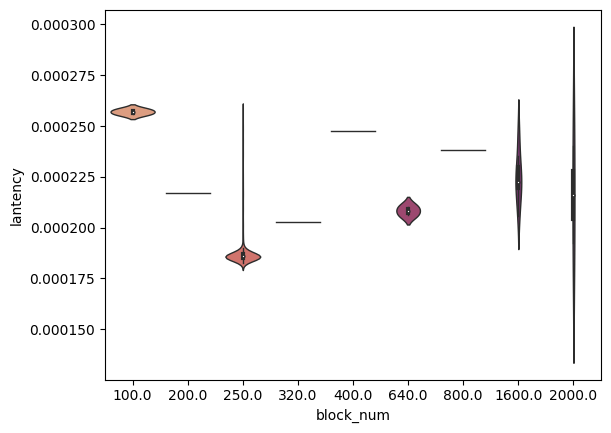

In [10]:
sns.violinplot(
    data=df_sort_lantency_top,
    x="block_num",
    y="lantency",
    linewidth=1,
    palette="flare",
)


/tmp/ipykernel_2011317/1036725490.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot: xlabel='block_num', ylabel='sm_cost'>

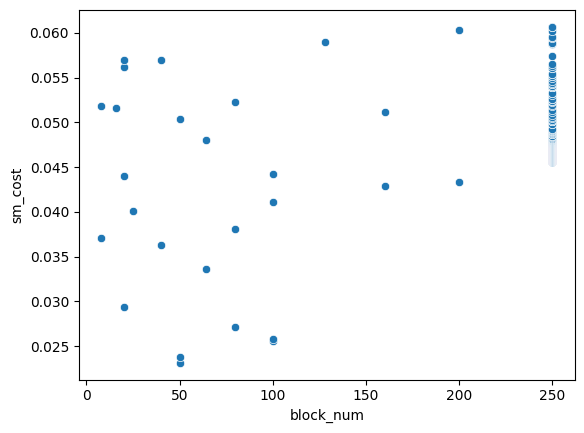

In [11]:
sns.scatterplot(
    data=df_sort_sm_cost_top,
    x="block_num",
    y="sm_cost",
    # hue="lantency",
    # hue_norm=(df_sort_sm_cost_top.min()["lantency"], df_sort_sm_cost_top.max()["lantency"]),
    # linewidth=0.5,
    palette="flare",
    # legend="brief",
)


[None, None]

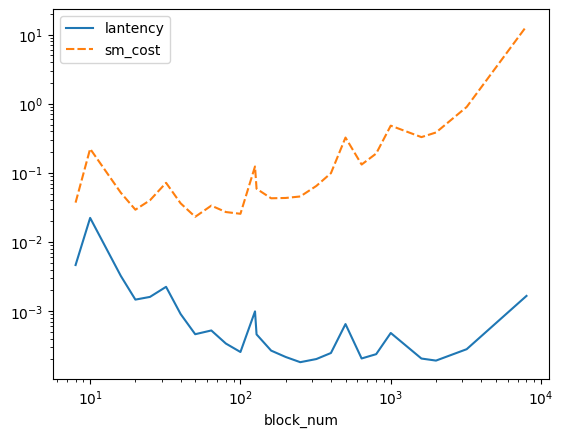

In [12]:
sns.lineplot(
    df.groupby("block_num")[["lantency", "sm_cost"]].min(),
).set(xscale="log", yscale="log")


In [15]:
print(df.groupby("block_num")[["lantency", "sm_cost"]].min())


           lantency    sm_cost
block_num                     
8.0        0.004643   0.037140
10.0       0.022325   0.223248
16.0       0.003228   0.051650
20.0       0.001467   0.029336
25.0       0.001605   0.040126
32.0       0.002246   0.071870
40.0       0.000907   0.036268
50.0       0.000463   0.023156
64.0       0.000525   0.033590
80.0       0.000339   0.027142
100.0      0.000256   0.025597
125.0      0.000991   0.123926
128.0      0.000460   0.058935
160.0      0.000268   0.042925
200.0      0.000217   0.043380
250.0      0.000182   0.045594
320.0      0.000203   0.064812
400.0      0.000248   0.099070
500.0      0.000649   0.324674
640.0      0.000206   0.132079
800.0      0.000238   0.190604
1000.0     0.000483   0.482520
1600.0     0.000206   0.329442
2000.0     0.000192   0.384582
3200.0     0.000281   0.899697
8000.0     0.001660  13.276760


In [14]:
from brt.jit.tvm.tuner import TVMTuner

tuner = TVMTuner()
tuner.import_pt_netlet(
    module_name="Conv2dBias",
    method="forward",
    module=nn.Conv2d(50, 50, 3, padding=1),
    input_infos={"input_0": [50, 50, 32, 32]},
    output_infos={"output_0": [50, 50, 32, 32]},
    parameters={
        "in_channels": 50,
        "out_channels": 50,
        "kernel_size": (3, 3),
        "stride": (1, 1),
        "padding": (1, 1),
        "dilation": (1, 1),
        "groups": 1,
        # "padding_mode": "zeros",
    },
)
print(tuner._get_best_template("fastest")[:2])


Get devices for measurement successfully!


/home/v-louyang/brainstorm_project/brainstorm/3rdparty/tvm/python/tvm/driver/build_module.py:267: UserWarning: target_host parameter is going to be deprecated. Please pass in tvm.target.Target(target, host=target_host) instead.
  warnings.warn(


((250, 1, 1), (128, 1, 1))
